In [1]:
from mvnx import MVNX
import pandas as pd
import openpyxl
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import numpy as np

In [100]:
xsense = MVNX('../CHOLE_Robot_Joystick_M-001.mvnx')

xsense_joint_angles = pd.DataFrame(xsense.jointAngle, columns=[f"{joint}_{axis}" for joint in xsense.joints.keys() for axis in ['X', 'Y', 'Z']])
xsense_joint_angles['Timecode'] = xsense.timecode
xsense_joint_angles['Time'] = xsense.time

## CAUTION I cannot intepret what these columns mean
xsense_center_of_mass = pd.DataFrame(xsense.centerOfMass, columns=[f"{unnamed}_{axis}" for unnamed in ['1','2','3','4','5','6'] for axis in ['X', 'Y', 'Z']])
xsense_center_of_mass['Timecode'] = xsense.timecode
xsense_center_of_mass['Time'] = xsense.time

vicon_rula = pd.read_csv("../comprehensive_rula_vicon.csv")
vicon_positions = pd.read_excel("../Vicon_Keypoints_Data.xlsx", sheet_name=None)


In [106]:
sheet_names = pd.ExcelFile('../CHOLE_Robot_Joystick_M-001.xlsx').sheet_names

In [122]:
xsense_from_xlsx_segment_position = pd.read_excel('../CHOLE_Robot_Joystick_M-001.xlsx', sheet_name="Segment Position")
xsense_from_xlsx_segment_position['Timecode'] = xsense.timecode
xsense_from_xlsx_segment_position['Time'] = xsense.time

In [123]:
xsense_from_xlsx_segment_position.columns

Index(['Frame', 'Pelvis x', 'Pelvis y', 'Pelvis z', 'L5 x', 'L5 y', 'L5 z',
       'L3 x', 'L3 y', 'L3 z', 'T12 x', 'T12 y', 'T12 z', 'T8 x', 'T8 y',
       'T8 z', 'Neck x', 'Neck y', 'Neck z', 'Head x', 'Head y', 'Head z',
       'Right Shoulder x', 'Right Shoulder y', 'Right Shoulder z',
       'Right Upper Arm x', 'Right Upper Arm y', 'Right Upper Arm z',
       'Right Forearm x', 'Right Forearm y', 'Right Forearm z', 'Right Hand x',
       'Right Hand y', 'Right Hand z', 'Left Shoulder x', 'Left Shoulder y',
       'Left Shoulder z', 'Left Upper Arm x', 'Left Upper Arm y',
       'Left Upper Arm z', 'Left Forearm x', 'Left Forearm y',
       'Left Forearm z', 'Left Hand x', 'Left Hand y', 'Left Hand z',
       'Right Upper Leg x', 'Right Upper Leg y', 'Right Upper Leg z',
       'Right Lower Leg x', 'Right Lower Leg y', 'Right Lower Leg z',
       'Right Foot x', 'Right Foot y', 'Right Foot z', 'Right Toe x',
       'Right Toe y', 'Right Toe z', 'Left Upper Leg x', 'Left Upper Leg

In [76]:
xsense_from_xlsx_center_of_mass = pd.read_excel('../CHOLE_Robot_Joystick_M-001.xlsx', sheet_name='Center of Mass')

In [124]:
vicon_positions.keys()

dict_keys(['Neck', 'Right Shoulder', 'Right Elbow', 'Right Wrist', 'Left Shoulder', 'Left Wrist', 'Mid Hip', 'Right Hip', 'Left Hip', 'Right Ear', 'Left Ear'])

In [125]:
# giving the vicon data some estimated time info from the xsense data
# some positions still missing due to error [:7]
vicon_positions_dfs = {}
for key in list(vicon_positions.keys())[:7]:
    #df = pd.DataFrame(vicon_positions[key], columns=['X', 'Y', 'Z'])
    df = vicon_positions[key].copy()
    df.loc[:,'Timecode_from_xsense'] = str("0")
    df.loc[:,'Timecode_from_xsense'][:len(xsense_center_of_mass['Timecode'])] = xsense_center_of_mass['Timecode'].values.astype(str)
    # !!!! remaining values must still be filled or handles appropriately
    df.loc[:,'Time'] = int(0)
    df.loc[:,'Time'][:len(xsense_center_of_mass['Time'])] = xsense_center_of_mass['Time'].values.astype(int) 
    vicon_positions_dfs[key] = df

C:\Users\gu95gif\AppData\Local\Temp\ipykernel_28008\1442325910.py:8: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


C:\Users\gu95gif\AppData\Local\Temp\ipykernel_28008\1442325910.py:8: SettingWithCopyWarning:


A value is trying to be set on 

In [126]:
vicon_positions_dfs['Neck']

,X,Y,Z,Timecode_from_xsense,Time
0,948.805054,808.972168,1559.997559,12:03:15:01,0
1,948.668701,809.121582,1559.931885,12:03:15:03,17
2,948.548767,809.255371,1559.872437,12:03:15:04,34
3,948.445251,809.373352,1559.819336,12:03:15:04,50
4,948.357910,809.475708,1559.772339,12:03:15:06,67
...,...,...,...,...,...
85929,1079.003906,664.109436,1537.778809,0,0
85930,1079.190918,664.157410,1537.687744,0,0
85931,1079.380371,664.208801,1537.593262,0,0
85932,1079.572266,664.263672,1537.495117,0,0


In [133]:
xsense_from_xlsx_segment_position_mm = xsense_from_xlsx_segment_position.assign(
    **{col: xsense_from_xlsx_segment_position[col] * 1000 for col in ['Neck x', 'Neck y', 'Neck z']}
)[['Neck x', 'Neck y', 'Neck z', 'Timecode', 'Time']]

In [142]:
# make a plotly 2d plot of the vicon_positions_dfs['Neck'] X and Y data from the first 1000 rows and the xsense_from_xlsx_segment_position['Neck x', 'Neck y'] data from the first 1000 rows
start = 0
end = 400

fig = go.Figure()
fig.add_trace(go.Scatter(x=vicon_positions_dfs['Neck']['X'][start:end], y=vicon_positions_dfs['Neck']['Y'][start:end], mode='markers', name='Vicon Neck'))  
fig.add_trace(go.Scatter(x=xsense_from_xlsx_segment_position_mm['Neck x'][start:end], y=xsense_from_xlsx_segment_position_mm['Neck y'][start:end], mode='markers', name='Xsense Neck'))
fig.update_layout(title='Vicon vs Xsense Neck Position', xaxis_title='X Position    ', yaxis_title='Y Position')
fig.show()

In [160]:
# make a plotly line plot of the vicon_positions_dfs['Neck'] X and Time data from the first 10000 rows and the xsense_from_xlsx_segment_position['Neck x'] and time data from the first 10000 rows
start = 0
end = 85000
#end = len(vicon_positions_dfs['Neck'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=vicon_positions_dfs['Neck']['Time'][start:end], y=vicon_positions_dfs['Neck']['X'][start:end], mode='lines', name='Vicon Neck X'))
fig.add_trace(go.Scatter(x=xsense_from_xlsx_segment_position_mm['Time'][start:end], y=xsense_from_xlsx_segment_position_mm['Neck x'][start:end], mode='lines', name='Xsense Neck X'))
fig.update_layout(title='Vicon vs Xsense Neck X Position over Time', xaxis_title='Time [ms]', yaxis_title='X Position (mm)')
fig.show()



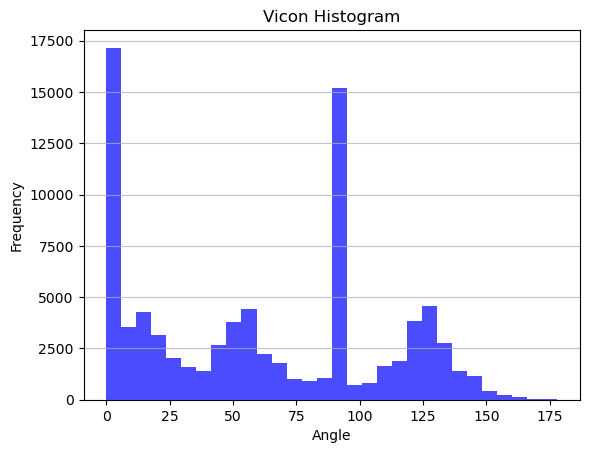

In [64]:
plt.hist(vicon_rula.LowerArmAngle, bins=30, color='blue', alpha=0.7)
plt.title('Vicon Histogram')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

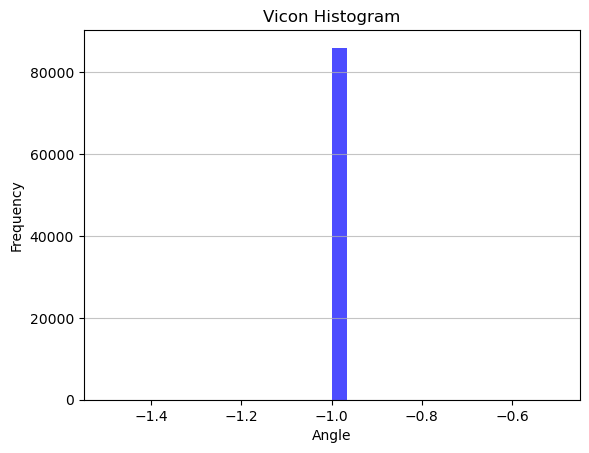

In [65]:
plt.hist(vicon_rula.TrunkAngle, bins=30, color='blue', alpha=0.7)
plt.title('Vicon Histogram')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()